# Project Description

**The Question**: Which features of public schools predict above-average school ranking?

This project uses data that I purchased and loaded from the GreatSchools.org API in 2021. The API endpoint for school rankings and demographics data was defined by a radius of geographical distance from Mount Kisco, NY, where I lived at the time. 

In all likelihood, I will purchase more data from GreatSchools to perform a 4-year comparison.


**What the GreatSchools Rating measures:**

The GreatSchools Rating is a 1–10 score, purchased by real estate listing aggregators like Zillow. Ratings at the lower end of the scale (1–4) signal below-average performance, 5–6 indicate average performance, and 7–10 demonstrate above-average performance.

The GreatSchools Rating is based on up to three themed ratings, which are designed to capture different aspects of school quality:

1) Student Progress Rating: Calculated using state-reported student growth data. If unavailable, it is replaced with the Academic Progress Rating, a proxy growth measure GreatSchools creates when sufficient state-produced student growth data is not available.
2) College Readiness Rating: A multi-measure rating based on college entrance exams (SAT and ACT), high school graduation rates, and advanced coursework participation (Advanced Placement (AP), International Baccalaureate (IB), or dual enrollment).
3) Test Score Rating: Based on state-standardized test performance.

GreatSchools calculate the 1-10 Rating using a two-step weighted average approach.
1) First, they assign base weights to each themed rating based on the strength of research linking that data to long-term student outcomes and our mission to highlight schools that support academic growth for all students. 
2) Second, they apply information weights that reflect the quantity and variability of data available for each themed rating. To maintain balance, these weights are capped so that no themed rating can outweigh the Student Progress Rating (or the Academic Progress Rating if growth data is not available). If any themed ratings are missing, the remaining weights are rebalanced to sum to one.

For more detail, see: https://www.greatschools.org/gk/about/ratings-methodology/


# Imports Table

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split


from sklearn.preprocessing import StandardScaler

from sklearn.base import BaseEstimator, TransformerMixin # for ILR transform

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# Custom Exponential Notation
def smart_num_format(x):
    if abs(x) < 9_999_999:
        return f"{x:.4f}"
    else:
        return f"{x:.4e}"
pd.set_option('display.float_format', smart_num_format)

from xgboost import XGBClassifier

# EDA

Data consists of two tables, which I constructed by parsing the JSON emitted from the GreatSchools.org API.

1) schools_raw - Describes location, grade level, rating, and distance to origin
- 2,349 schools
- id (joined to Universal_ID in demographics)
- 13 feature columns



2) demog_raw - Describes enrollment, teacher salaries, student-teacher ratio, socioeconomic class markers, racial composition
- 1,598 schools
- Universal_ID
- 18 feature columns



In [2]:
# read in schools raw data
schools_raw = pd.read_csv('schools_data_BACKUP.csv')
schools = schools_raw.copy()

In [3]:
schools.head(2)

,id,name,type,level,level_codes,city,state,zip_code,district,latitude,longitude,rating,rating_year,distance
0,3605242,The Karafin School,private,"9,10,11,12",h,Mount Kisco,NY,10549,NaN,41.2043,-73.7271,NaN,NaN,0.3483
1,3607320,Talmud Torah Bais Yechiel-Nitra,private,"PK,KG,1,2,3,4,5,6,7,8,9","p,e,m",Mount Kisco,NY,11211,NaN,41.2043,-73.7271,NaN,NaN,0.3483


In [4]:
schools.shape

(2439, 14)

In [5]:
# read in demographics raw data
demog_raw = pd.read_csv('demographics_mstr_BACKUP.csv')
demog = demog_raw.copy()

In [6]:
demog.shape

(1598, 19)

In [7]:
demog.head(2)

,enrollment,percent-reduced-lunch,percent-disadvantaged,percent-limited-english,average-salary,student-teacher-ratio,student-counselor-ratio,percentage-female,teachers-experience,percentage-certified,Universal_ID,Hispanic,White,African American,Asian,Native Hawaiian or Other Pacific Islander,Two or more races,Native American,Asian or Pacific Islander
0,72.0000,NaN,NaN,NaN,NaN,NaN,NaN,44.4444,NaN,NaN,3605242,43.0556,34.7222,19.4444,2.7778,0.0000,0.0000,0.0000,NaN
1,231.0000,NaN,NaN,NaN,NaN,NaN,NaN,40.2597,NaN,NaN,3607320,0.0000,100.0000,0.0000,0.0000,0.0000,0.0000,0.0000,NaN


In [8]:
# merge right on 'id', left on 'Universal_ID'

df = schools.merge(demog, left_on='id', right_on='Universal_ID', how='outer')

In [9]:
# inspect merge results

df.head()

,id,name,type,level,level_codes,city,state,zip_code,district,latitude,...,percentage-certified,Universal_ID,Hispanic,White,African American,Asian,Native Hawaiian or Other Pacific Islander,Two or more races,Native American,Asian or Pacific Islander
0,3605242,The Karafin School,private,"9,10,11,12",h,Mount Kisco,NY,10549,NaN,41.2043,...,NaN,3605242.0000,43.0556,34.7222,19.4444,2.7778,0.0000,0.0000,0.0000,NaN
1,3607320,Talmud Torah Bais Yechiel-Nitra,private,"PK,KG,1,2,3,4,5,6,7,8,9","p,e,m",Mount Kisco,NY,11211,NaN,41.2043,...,NaN,3607320.0000,0.0000,100.0000,0.0000,0.0000,0.0000,0.0000,0.0000,NaN
2,3601714,Mount Kisco Elementary School,public,"KG,1,2,3,4,5",e,Mount Kisco,NY,10549,Bedford Central School District,41.2026,...,100.0000,3601714.0000,66.2768,25.1462,2.5341,NaN,0.0000,3.3138,0.0000,2.7290
3,3601716,West Patent Elementary School,public,"KG,1,2,3,4,5,UG",e,Bedford Hills,NY,10507,Bedford Central School District,41.2142,...,100.0000,3601716.0000,31.0231,54.7855,2.6403,NaN,0.0000,4.6205,0.3300,6.6007
4,3615676,The Country Childrens Center,private,"PK,KG","p,e",Bedford Hills,NY,10507,NaN,41.2341,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# look for big patterns

df[df.columns.difference(['id','rating_year', 'Universal_ID'])].describe().T

,count,mean,std,min,25%,50%,75%,max
African American,1589.0000,16.9784,19.9360,0.0000,2.0000,8.8900,25.7143,100.0000
Asian,336.0000,8.6201,16.7628,0.0000,0.0000,2.8208,9.1438,100.0000
Asian or Pacific Islander,1256.0000,7.4748,10.3306,0.0000,1.1839,3.5177,8.9161,67.8571
Hispanic,1598.0000,37.4479,28.0451,0.0000,11.0742,32.3637,62.7826,100.0000
Native American,1472.0000,0.4195,1.0481,0.0000,0.0000,0.1470,0.5185,29.9517
Native Hawaiian or Other Pacific Islander,1492.0000,0.3062,0.9814,0.0000,0.0000,0.0000,0.3120,20.1613
Two or more races,1577.0000,2.3775,4.4242,0.0000,0.2183,1.0496,3.1830,100.0000
White,1597.0000,34.9844,33.3198,0.0000,2.1912,25.0000,66.6667,100.0000
average-salary,1206.0000,87643.9103,21119.2413,0.0000,75181.9350,84421.1900,97947.5375,201470.0000
distance,2439.0000,22.6755,6.1351,0.3483,19.1617,24.8189,27.3608,29.9997


Text(0.5, 1.0, 'Distribution of School Ratings')

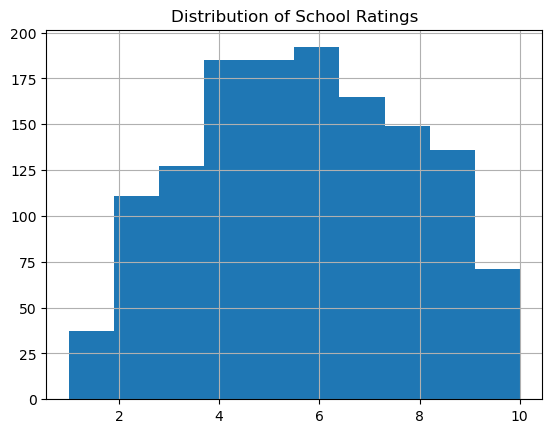

In [11]:
# observe distribution of school ratings

df['rating'].hist()
plt.title('Distribution of School Ratings')

In [12]:
# check for duplicates in main identifier

df[df.duplicated(subset='id', keep=False)]

,id,name,type,level,level_codes,city,state,zip_code,district,latitude,...,percentage-certified,Universal_ID,Hispanic,White,African American,Asian,Native Hawaiian or Other Pacific Islander,Two or more races,Native American,Asian or Pacific Islander


In [13]:
# schools per district

df['district'].value_counts()

New York City Geographic District #10                 85
New York City Geographic District # 9                 69
New York City Geographic District #11                 62
New York City Geographic District # 8                 56
New York City Geographic District #12                 50
                                                      ..
Grand Concourse Academy Charter School                 1
Bronx Preparatory Charter School                       1
Urban Assembly Charter School for Computer Science     1
Icahn Charter School 1                                 1
New York City Geographic District #26                  1
Name: district, Length: 302, dtype: int64

In [14]:
# mean rating by district

(
    df.groupby(by='district')['rating']
    .agg(mean='mean').sort_values(by='mean', ascending=False).head(50)
)



,mean
district,
Academic Leadership Charter School,10.0000
Oradell Public School District,10.0000
Englewood Cliffs School District,10.0000
Icahn Charter School 3,10.0000
Bronx Charter School for Excellence 2,10.0000
Allendale Public School District,10.0000
New York City Geographic District #26,10.0000
Success Academy Charter School-Bronx 2,10.0000
Northern Valley Regional High School District,10.0000


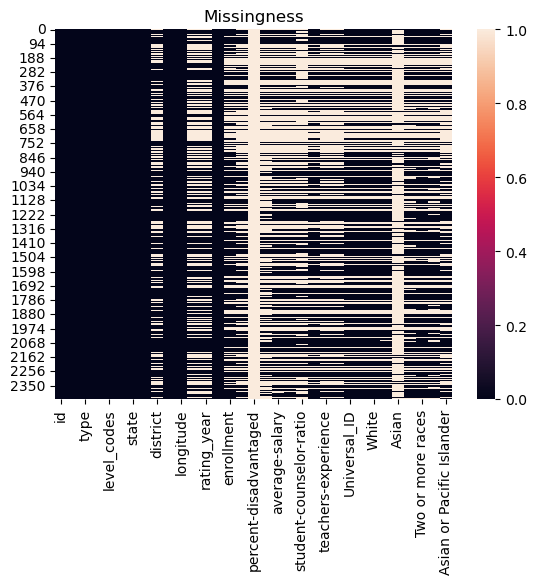

In [15]:
# missingness

sns.heatmap(df.isnull())
plt.title('Missingness')
plt.show()

In [16]:
# percent null

(df.isnull().sum()/len(df)*100).sort_values(ascending=False)

percent-disadvantaged                       100.0000
Asian                                        86.2239
student-counselor-ratio                      61.9926
percent-limited-english                      61.0086
average-salary                               50.5535
percentage-certified                         50.5125
teachers-experience                          50.4715
student-teacher-ratio                        50.4715
percent-reduced-lunch                        49.3235
Asian or Pacific Islander                    48.5035
rating_year                                  44.3214
rating                                       44.3214
Native American                              39.6474
district                                     38.9504
Native Hawaiian or Other Pacific Islander    38.8274
percentage-female                            36.2444
Two or more races                            35.3424
African American                             34.8503
enrollment                                   3

In [17]:
# drop 100% null column

df = df.drop(columns=['percent-disadvantaged'])

In [18]:
# cross join on district to fill average salary?
# check if each school district has one unique "average salary"

unique_salary = (
    df.groupby(by='district')['average-salary']
    .agg(nunique='nunique').sort_values(by='nunique')['nunique'].eq(1)
)

unique_salary

district
Abbott Union Free School District                                False
New York State Office Mental Health (Office of Mental Health)    False
New Milford School District                                      False
New Fairfield School District                                    False
New Canaan School District                                       False
                                                                 ...  
New York City Geographic District #12                            False
New York City Geographic District # 8                            False
New York City Geographic District #11                            False
New York City Geographic District # 9                            False
New York City Geographic District #10                            False
Name: nunique, Length: 302, dtype: bool

In [19]:
#inspect salaries per district
df.dropna(subset='district').set_index(['district','average-salary']).head()

id  \
district                          average-salary            
Bedford Central School District   102982.1500     3601714   
                                  122886.8000     3601716   
                                  109263.8200     3601711   
Chappaqua Central School District 100143.0000     3607765   
                                  117754.0200     3600514   

                                                                             name  \
district                          average-salary                                    
Bedford Central School District   102982.1500       Mount Kisco Elementary School   
                                  122886.8000       West Patent Elementary School   
                                  109263.8200     Bedford Hills Elementary School   
Chappaqua Central School District 100143.0000         Seven Bridges Middle School   
                                  117754.0200          Horace Greeley High School   

                                                    type            level  \
district                          average-salary                            
Bedford Central School District   102982.1500     public     KG,1,2,3,4,5   
                                  122886.8000     public  KG,1,2,3,4,5,UG   
                                  109263.8200     public  KG,1,2,3,4,5,UG   
Chappaqua Central School District 100143.0000     public          5,6,7,8   
                                  117754.0200     public    9,10,11,12,UG   

                                                 level_codes           city  \
district                          average-salary                              
Bedford Central School District   102982.1500              e    Mount Kisco   
                                  122886.8000              e  Bedford Hills   
                                  109263.8200              e  Bedford Hills   
Chappaqua Central School District 100143.0000            e,m      CHAPPAQUA   
                                  117754.0200              h      Chappaqua   

                                                 state  zip_code  latitude  \
district                          average-salary                             
Bedford Central School District   102982.1500       NY     10549   41.2026   
                                  122886.8000       NY     10507   41.2142   
                                  109263.8200       NY     10507   41.2365   
Chappaqua Central School District 100143.0000       NY     10514   41.2070   
                                  117754.0200       NY     10514   41.1744   

                                                  longitude  ...  \
district                          average-salary             ...   
Bedford Central School District   102982.1500      -73.7285  ...   
                                  122886.8000      -73.7028  ...   
                                  109263.8200      -73.6934  ...   
Chappaqua Central School District 100143.0000      -73.7722  ...   
                                  117754.0200      -73.7550  ...   

                                                  percentage-certified  \
district                          average-salary                         
Bedford Central School District   102982.1500                 100.0000   
                                  122886.8000                 100.0000   
                                  109263.8200                 100.0000   
Chappaqua Central School District 100143.0000                 100.0000   
                                  117754.0200                 100.0000   

                                                  Universal_ID  Hispanic  \
district                          average-salary                           
Bedford Central School District   102982.1500     3601714.0000   66.2768   
                                  122886.8000     3601716.0000   31.0231   
                                  109263.8200     3601711.0000   50.7042   
Chappaqua Cent

In [20]:
# observe asian and 'Asian or Pacific Islander'

df[['Asian', 'Asian or Pacific Islander']] # appears to be an or-condition

bad_overlap = (df['Asian'].notna() & df['Asian or Pacific Islander'].notna())

assert not bad_overlap.any(), 'Columns not mergable in current form'

In [21]:
# merge asian and asian or pacific islander

df['Asian_combo'] = (
    df['Asian'].fillna(df['Asian or Pacific Islander'])
)

# drop original cols

df = df.drop(columns=['Asian', 'Asian or Pacific Islander'])


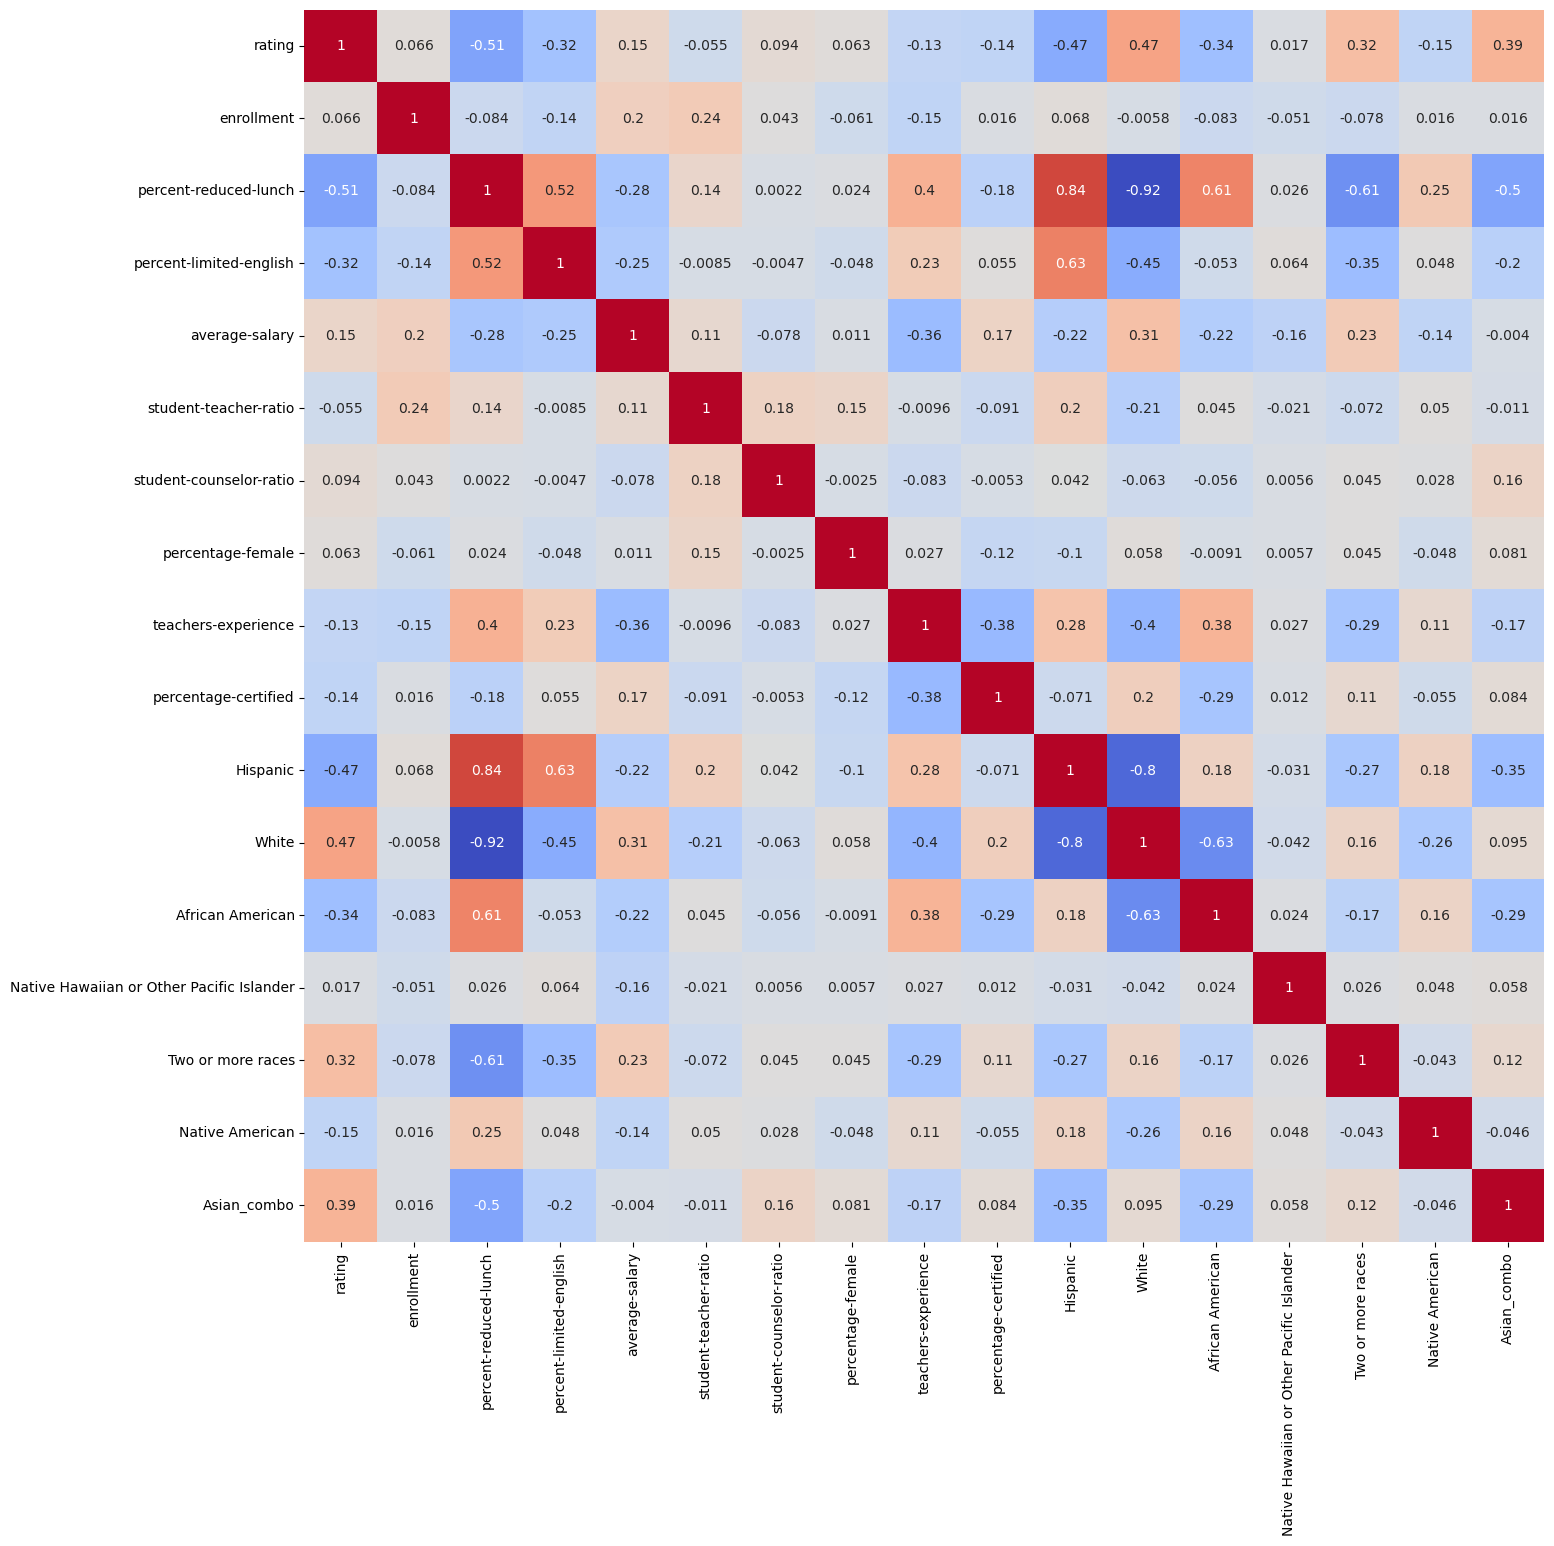

In [22]:
# inspect feature correlations with heatmap

fig, ax = plt.subplots(figsize=(16,16))
corr = df.drop(
    columns=['Universal_ID','id','zip_code','distance', 'rating_year','latitude', 'longitude']
).select_dtypes(include='number').corr()
sns.heatmap(corr, annot=True, cbar=False, cmap='coolwarm')
plt.show()

In [23]:
# drop data with no rating

df_rating = df.dropna(subset='rating').copy()

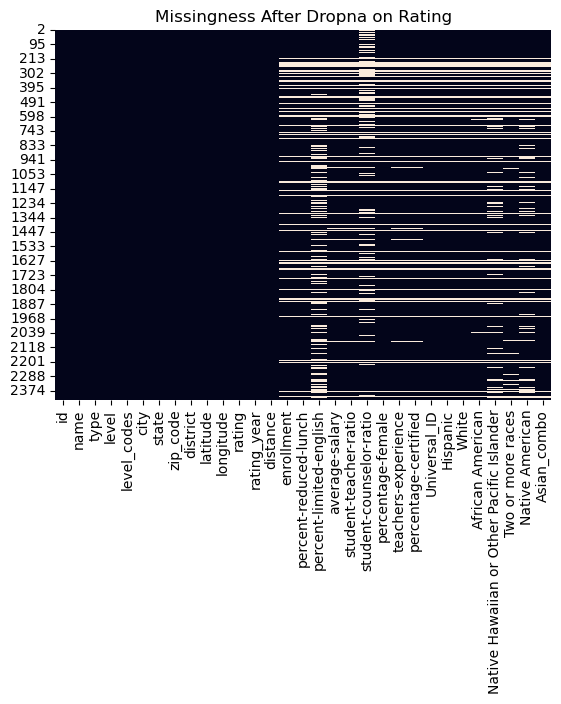

In [24]:
# check missingness after dropping blank ratings

sns.heatmap(df_rating.isna(), cbar=False)
plt.title('Missingness After Dropna on Rating')
plt.show()

In [25]:
#observe remaining missingness

(df_rating.isnull().sum()/len(df_rating)*100).sort_values(ascending=False)

student-counselor-ratio                     33.9470
percent-limited-english                     33.7261
Native American                             24.2268
Native Hawaiian or Other Pacific Islander   22.3859
Two or more races                           17.1576
percentage-certified                        16.8630
teachers-experience                         16.8630
student-teacher-ratio                       16.8630
average-salary                              16.8630
African American                            16.4212
Asian_combo                                 15.9794
White                                       15.8321
Hispanic                                    15.8321
Universal_ID                                15.8321
percentage-female                           15.8321
percent-reduced-lunch                       15.8321
enrollment                                  15.8321
name                                         0.0000
distance                                     0.0000
rating_year 

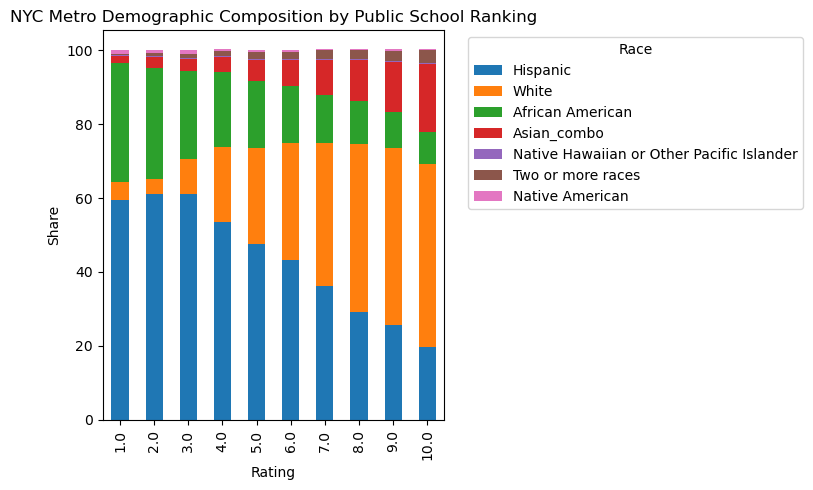

In [26]:
# stacked bar chart

demog_race = ['Hispanic', 'White','African American', 'Asian_combo', 
              'Native Hawaiian or Other Pacific Islander', 'Two or more races',
              'Native American']

plot_df = (
    df_rating
    .groupby('rating')[demog_race]
    .mean()     # or .sum(), depending on meaning
    .sort_index()
)

ax = plot_df.plot(kind='bar', stacked=True, figsize=(8, 5))
ax.set_ylabel('Share')
ax.set_xlabel('Rating')
ax.legend(title='Race', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("NYC Metro Demographic Composition by Public School Ranking")
plt.tight_layout()


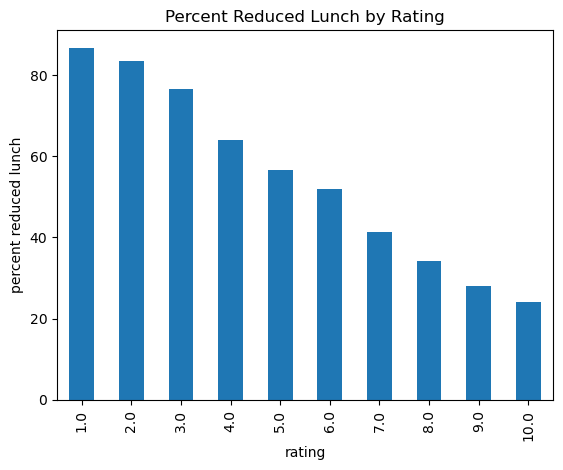

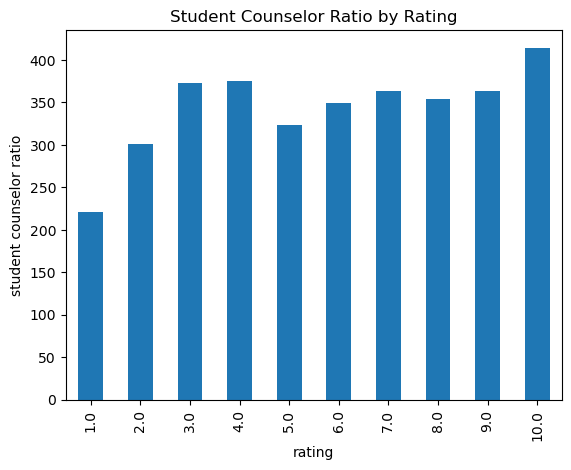

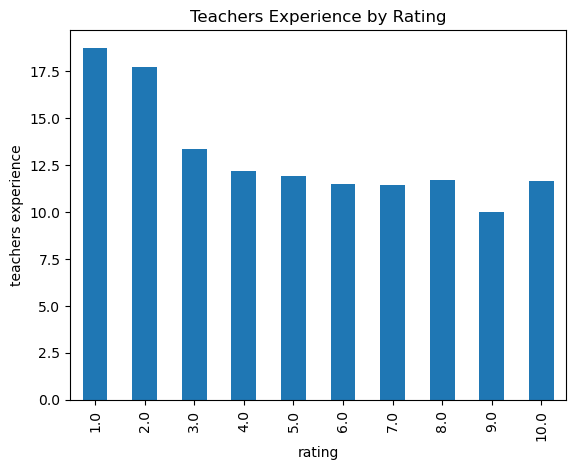

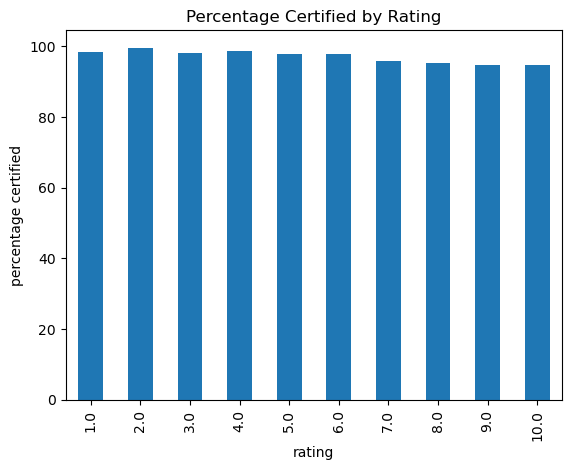

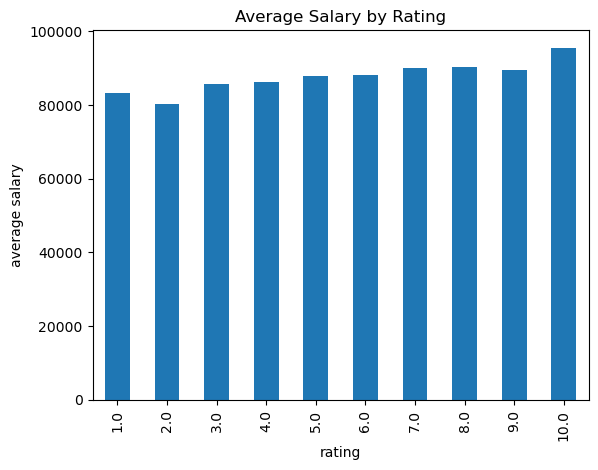

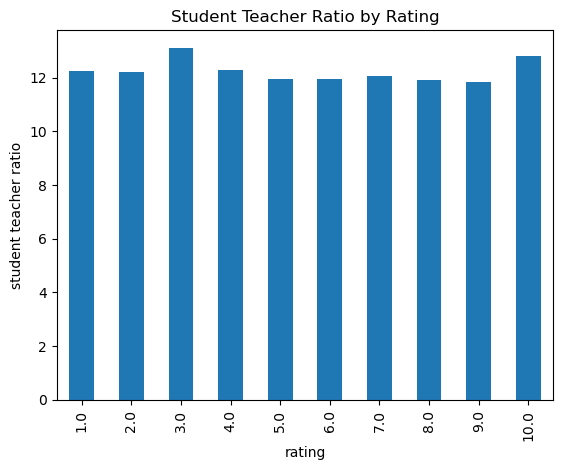

In [27]:
# model funding-related features


bar_cols = ['percent-reduced-lunch', 
'student-counselor-ratio', 
'teachers-experience', 
'percentage-certified', 
'average-salary',
           'student-teacher-ratio']

for col in bar_cols:
    plot_table = (df_rating.groupby('rating')[col]
    .agg(col='mean')
    .sort_index())
    
    plot_table.plot(kind='bar', legend=False)
    plt.title(f'{col.title().replace("-"," ")} by Rating')
    plt.ylabel(f"{col}".replace("-"," "))
    plt.show()

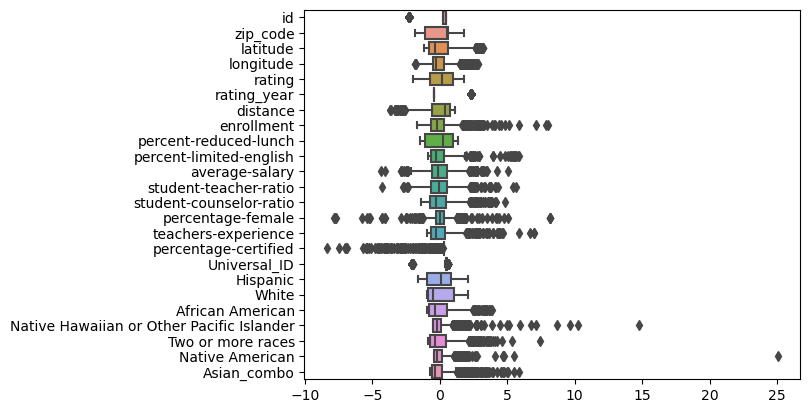

In [28]:
# check_for_outliers

scaler = StandardScaler() #apples to apples
scaled_array = scaler.fit_transform(df_rating.select_dtypes(include=['number']).copy())
df_scaled = pd.DataFrame(scaled_array,
                        columns=df_rating.select_dtypes(include=['number']).columns, 
                         index=df_rating.index)

df_scaled
sns.boxplot(df_scaled, orient='h')
plt.show()



In [29]:
# define simplex cols

simplex_cols = ['Hispanic', 'White',
       'African American', 'Native Hawaiian or Other Pacific Islander',
       'Two or more races', 'Native American', 'Asian_combo']


In [30]:
#check if any cols add to 100

#assert np.isclose(df_rating[simplex_cols].sum(axis=1), 100).all(), "Simplexes not all mathing"

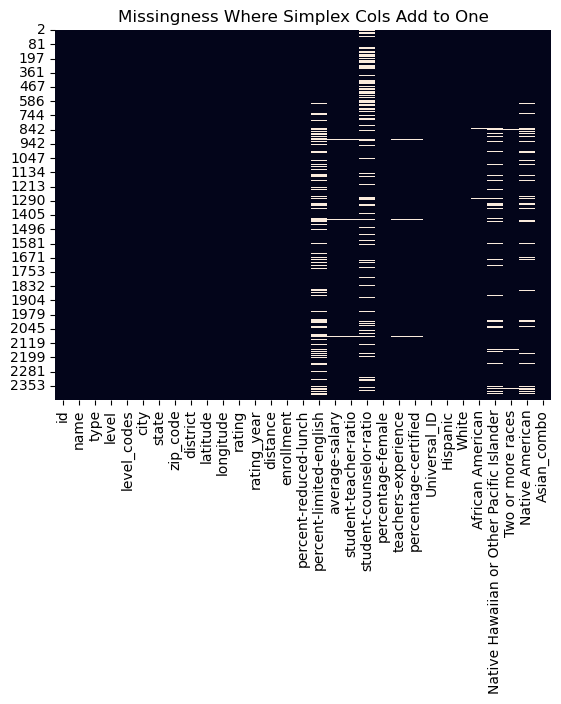

In [31]:
# rows where simplex columns are working

sns.heatmap(df_rating[np.isclose(df_rating[simplex_cols].sum(axis=1), 100, atol=0.01)].isna(), cbar=False)
plt.title('Missingness Where Simplex Cols Add to One')
plt.show()

In [32]:
# observe rows where simplexes do not add up

df_rating[~np.isclose(df_rating[['Hispanic', 'White',
       'African American', 'Native Hawaiian or Other Pacific Islander',
       'Two or more races', 'Native American', 'Asian_combo']].sum(axis=1), 100, atol=0.01)]['state'].value_counts()

# all rows are in the state of Connecticut, which maybe does not publish demographic data

CT    215
Name: state, dtype: int64

In [33]:
# drop rows where state is connecticut
# connecticut data could be useful in some other context

ct_rows = df_rating[df_rating['state']=='CT'].index

df_rating = df_rating.drop(ct_rows)

In [34]:
# verify that simplex columns now add all to one with Connecticut dropped
assert np.isclose(df_rating[['Hispanic', 'White',
       'African American', 'Native Hawaiian or Other Pacific Islander',
       'Two or more races', 'Native American', 'Asian_combo']].sum(axis=1), 100).all(), "Simplexes not mathing"

In [35]:
# fill null values in add-to-one columns with zeros
# if the columns add to one, the nulls represent zeros

df_rating[simplex_cols] = df_rating[simplex_cols].fillna(0.0)

## Changes Log

Dropped:
1) The "percent-disadvantaged" column, which was 100% blank
2) Rows (schools) where "rating" column was blank
3) All rows for the state of Connecticut, which lacked demographic data

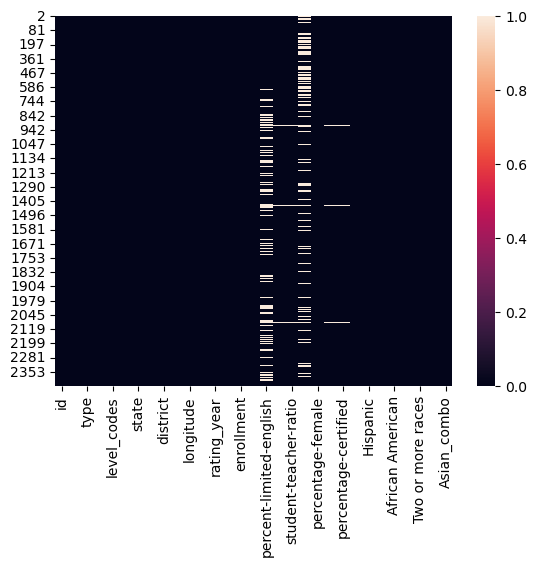

In [36]:
# check missingness again
sns.heatmap(df_rating.isnull())
plt.show()

In [37]:
# observe nulls
# could these be zeros in disguise?
nulls_cols = df_rating.columns[df_rating.isnull().sum()>0]

df_rating[nulls_cols]

,percent-limited-english,average-salary,student-teacher-ratio,student-counselor-ratio,teachers-experience,percentage-certified
2,31.5133,102982.1500,9.7900,NaN,12.5000,100.0000
3,9.7765,122886.8000,10.3200,NaN,0.0000,100.0000
6,23.1034,109263.8200,9.4300,NaN,16.6667,100.0000
7,0.0000,100143.0000,11.5100,195.6700,3.9216,100.0000
8,0.0000,117754.0200,11.7700,162.0000,3.6331,100.0000
...,...,...,...,...,...,...
2423,5.7143,95266.3700,9.2300,362.0400,4.7945,100.0000
2431,1.0000,109518.0000,13.7600,183.5000,7.5000,100.0000
2433,NaN,65567.6900,12.5000,241.6700,6.8966,100.0000
2435,NaN,84623.0700,16.5700,NaN,0.0000,100.0000


# Pipeline

I use sklearn Pipeline to manage preprocessing, modelling, cross-validation

In [38]:
# construct a binary target
mean_rating = df_rating['rating'].mean()

df_rating['above_average'] = np.where(df_rating['rating']>mean_rating, 1, 0)

In [39]:
# condense zip codes into smaller categories

df_rating['zip_4'] = df_rating['zip_code'].astype('str').str[0:4]

In [40]:
# create ILR transformer
class ILRTransformer(BaseEstimator, TransformerMixin):
    """
    Apply ILR transform to a set of compositional columns.
    X is expected to be a DataFrame when used standalone;
    inside ColumnTransformer it will be a NumPy array with only `cols`.
    """
    def __init__(self, cols, prefix="ilr"):
        self.cols = cols
        self.prefix = prefix
        self.V_ = None   # ILR basis (D-1 x D)
        self.feature_names_out_ = None

    def fit(self, X, y=None):
        D = len(self.cols)
        # Build a Helmert-like matrix to get an orthonormal basis
        H = np.zeros((D, D))
        for i in range(1, D):
            H[i, :i] = 1.0 / i
            H[i, i] = -1.0
        # QR on the (D x (D-1)) submatrix to get orthonormal columns
        Q, _ = np.linalg.qr(H[:, 1:])
        self.V_ = Q.T      # shape: (D-1, D)

        # tell sklearn how many features we output and what they’re called
        n_out = D - 1
        self.feature_names_out_ = np.array(
            [f"{self.prefix}_{j}" for j in range(n_out)],
            dtype=object
        )
        return self

    def transform(self, X):
        # handle both DataFrame and ndarray (inside ColumnTransformer)
        if isinstance(X, pd.DataFrame):
            Xs = X[self.cols].to_numpy(dtype=float)
        else:
            Xs = np.asarray(X, dtype=float)

        # Avoid log(0)
        Xs = np.clip(Xs, 1e-12, None)
        logX = np.log(Xs)
        clr = logX - logX.mean(axis=1, keepdims=True)  # n x D
        # ILR coords: n x (D-1)
        Z = clr @ self.V_.T
        return Z

    def get_feature_names_out(self, input_features=None):
        # ColumnTransformer will pass in the original feature names subset;
        # we just ignore and return our ILR coord names.
        return self.feature_names_out_


In [41]:
# pipeline

# define the columns
simplex_cols = simplex_cols

num_cols     = ['distance', 'enrollment', 'percent-reduced-lunch',
       'percent-limited-english', 'average-salary', 'student-teacher-ratio',
       'student-counselor-ratio', 'percentage-female', 'teachers-experience',
       'percentage-certified']   

cat_cols     = ["zip_4", 'state']   # not many states represented in the data


# numeric pipeline: impute + scale

cat_pipe = Pipeline([
    ("encode", OneHotEncoder(handle_unknown='ignore'))
    
])

num_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="mean", add_indicator=True)),
    ("scale", StandardScaler()),
])

ilr_pipe = Pipeline([
    ("ilr", ILRTransformer(simplex_cols)),
    ("scale", StandardScaler())
])


preprocess = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols),
        ("ilr", ilr_pipe, simplex_cols)
    ],
    remainder="drop",
)

logit_pipe = Pipeline([
    ("preprocess", preprocess),
    ("logit", LogisticRegression(max_iter=2000))
])

tree_pipe = Pipeline([
    ("preprocess", preprocess),
    ('tree', DecisionTreeClassifier())
])

xgb_pipe = Pipeline([
    ("preprocess", preprocess),   # same ColumnTransformer you already have
    ("xgb", XGBClassifier(random_state=21))
])



In [42]:
# split the data
X = df_rating[simplex_cols + cat_cols + num_cols]
y = df_rating['above_average']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

In [43]:
# decision tree model hyperparameter tuning


param_grid = {
    "tree__max_depth": [None, 3, 5, 10],
    "tree__min_samples_leaf": [1, 5, 10, 20, 30],
    "tree__min_samples_split": [2, 5, 10]
}

grid = GridSearchCV(
    tree_pipe,
    param_grid=param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
)

grid.fit(X_train, y_train)

grid.best_params_, grid.best_score_

({'tree__max_depth': 10,
  'tree__min_samples_leaf': 30,
  'tree__min_samples_split': 5},
 0.7675125550158981)

In [44]:
# tune the hyperparameters

from sklearn.model_selection import GridSearchCV

xgb_param_grid = {
    "xgb__n_estimators": [100, 300],
    "xgb__max_depth": [3, 5],
    "xgb__learning_rate": [0.05, 0.1],
}

xgb_gs = GridSearchCV(
    xgb_pipe,
    param_grid=xgb_param_grid,
    cv=5,
    scoring="accuracy",   # or whatever you’re using
    n_jobs=-1
)

xgb_gs.fit(X_train, y_train)

xgb_gs.best_params_, xgb_gs.best_score_


({'xgb__learning_rate': 0.05, 'xgb__max_depth': 5, 'xgb__n_estimators': 100},
 0.7327213382292943)

In [45]:
# redefine tree_pipe

best_tree_pipe = grid.best_estimator_

best_xgb_pipe = xgb_gs.best_estimator_

In [46]:
# keep pipes in a list

model_pipes_list = [("logit", logit_pipe), ("tree", best_tree_pipe), ('xgboost', best_xgb_pipe)]

In [47]:
# pipeline

score_table = []

for name, pipe in model_pipes_list:
    scores = cross_val_score(
        pipe,
        X_train,
        y_train,
        cv=25,
        scoring="accuracy"   # or "accuracy", etc.
    )
    
    score_table.append({
        "model": name,
        "mean_score": scores.mean(),
        "cv_scores": scores
    })

pd.DataFrame(score_table)


,model,mean_score,cv_scores
0,logit,0.7053,"[0.7714285714285715, 0.8571428571428571, 0.8, ..."
1,tree,0.6988,"[0.7714285714285715, 0.6571428571428571, 0.685..."
2,xgboost,0.7208,"[0.7142857142857143, 0.7714285714285715, 0.742..."


In [48]:
# test scores

test_scores = []

for name, pipe in model_pipes_list:
    
    pipe.fit(X_train, y_train)
    
    test_scores.append({
        "model" : name,
        "test_score" : pipe.score(X_test, y_test)
    })
    
pd.DataFrame(test_scores)

,model,test_score
0,logit,0.6888
1,tree,0.7203
2,xgboost,0.7028


In [49]:
# get some visibility into this thing
# observe feature names

X = df_rating[simplex_cols + cat_cols + num_cols]
y = df_rating['above_average']

logit_pipe.fit(X, y)

ct = logit_pipe.named_steps["preprocess"]

X_trans = ct.transform(X) 

feature_names = ct.get_feature_names_out()
print(feature_names)

['num__distance' 'num__enrollment' 'num__percent-reduced-lunch'
 'num__percent-limited-english' 'num__average-salary'
 'num__student-teacher-ratio' 'num__student-counselor-ratio'
 'num__percentage-female' 'num__teachers-experience'
 'num__percentage-certified'
 'num__missingindicator_percent-limited-english'
 'num__missingindicator_average-salary'
 'num__missingindicator_student-teacher-ratio'
 'num__missingindicator_student-counselor-ratio'
 'num__missingindicator_teachers-experience'
 'num__missingindicator_percentage-certified' 'cat__zip_4_1002'
 'cat__zip_4_1003' 'cat__zip_4_1004' 'cat__zip_4_1045' 'cat__zip_4_1046'
 'cat__zip_4_1047' 'cat__zip_4_1050' 'cat__zip_4_1051' 'cat__zip_4_1052'
 'cat__zip_4_1053' 'cat__zip_4_1054' 'cat__zip_4_1055' 'cat__zip_4_1056'
 'cat__zip_4_1057' 'cat__zip_4_1058' 'cat__zip_4_1059' 'cat__zip_4_1060'
 'cat__zip_4_1070' 'cat__zip_4_1071' 'cat__zip_4_1080' 'cat__zip_4_1090'
 'cat__zip_4_1091' 'cat__zip_4_1092' 'cat__zip_4_1095' 'cat__zip_4_1096'
 'cat__

In [50]:
# logistic feature importances

clf = logit_pipe.named_steps["logit"]

coefs = clf.coef_.ravel()  # (n_features,)
feature_names = ct.get_feature_names_out()

coef_df = (
    pd.DataFrame({"feature": feature_names, "coef": coefs})
      .assign(abs_coef=lambda d: d["coef"].abs())
      .sort_values("abs_coef", ascending=False)
)

coef_df[100:150]

,feature,coef,abs_coef
111,cat__zip_4_7644,0.1485,0.1485
115,cat__zip_4_7648,0.1467,0.1467
107,cat__zip_4_7640,0.1462,0.1462
108,cat__zip_4_7641,0.1422,0.1422
23,cat__zip_4_1051,-0.1420,0.1420
52,cat__zip_4_1170,0.1314,0.1314
97,cat__zip_4_7608,0.1202,0.1202
3,num__percent-limited-english,-0.1178,0.1178
121,cat__zip_4_7660,-0.1106,0.1106
10,num__missingindicator_percent-limited-english,0.1091,0.1091
